In [40]:
import pandas as pd
import catboost as cb
import numpy as np

In [32]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;}</style>"))

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display


In [34]:
import shap

In [35]:
main_df = pd.read_excel('./main_df_dropna_completed.xlsx',index_col=0)

In [36]:
main_df = main_df[['회사명', '거래소코드', '회계년도', '유동비율(%)', '당좌비율(%)', '비유동비율(%)', '부채비율(%)',
       '유동부채비율(%)', '차입금의존도(%)', '이익잉여금비율(%)', '순운전자본비율(%)', '비유동장기적합률(%)',
       '이자보상배율(이자비용)(배)', '외화포지션(배)', '총자본순이익률(%)', '자기자본순이익률(%)',
       '경영자본순이익률(%)', '매출액순이익률(%)', '총자본정상영업이익률(%)', '자기자본정상영업이익률(%)',
       '매출액정상영업이익률(%)', '금융비용부담률(%)', '총자산회전율(배)', '매출채권회전률(배)', '당좌자산회전률(배)',
       '재고자산회전률(배)', '유형자산회전율(배)', '매입채무회전률(배)', '자기자본회전률(배)', '경영자본회전률(배)',
       '유동자산증가율(%)', '매출액증가율(%)', '정상영업이익증가율(%)', '순이익증가율(%)', 'spread(%)',
       'PPI(2015기준)', '실질GDP성장률(%)', 'EV/EBITDA(배)', '52주베타(배)', 'PER', 'PBR',
       'PCR', 'CASH FLOW 대 부채비율(%)', '총자본투자효율(%)', 'log_평균총자산', 'K2_score',
        '산업위험_경기민감도', '최대주주특수관계인_지분율(%)', '최대주주변경횟수(회)',
       '감사법인변경횟수(회)', '업력(년)', '평균근속연수(년)', '직원수증감율(%)', '기간제비율(%)',
       'R&D집중도(%)', '수출기업여부(dummy)', '주거래은행', 'Target']]

In [37]:
df_train = main_df.loc[main_df['회계년도'] <= 2019]
df_test = main_df.loc[main_df['회계년도'] > 2019]

In [38]:
train_x  = df_train.drop(['Target','회사명', '거래소코드', '회계년도'], axis=1)
train_y = df_train['Target']

test_X= df_test.drop(['회사명', '거래소코드', '회계년도'],axis=1)
test_y = df_test['Target']

In [43]:
cat_features = list(train_x.select_dtypes("object"))

In [47]:
train_dataset = cb.Pool(train_x , train_y,cat_features=cat_features)
model = cb.CatBoostClassifier(verbose=False)

In [48]:
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.05,0.07,0.1],
        'depth': [6, 8,10],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}

In [49]:
model_result = model.randomized_search(grid, train_dataset,n_iter=2,
                        plot=False,
                        verbose=False,partition_random_seed=0)


bestTest = 0.1631801545
bestIteration = 199


bestTest = 0.1717666007
bestIteration = 145

Training on fold [0/3]

bestTest = 0.14003382
bestIteration = 193

Training on fold [1/3]

bestTest = 0.1521644641
bestIteration = 172

Training on fold [2/3]

bestTest = 0.1787064217
bestIteration = 169



In [50]:
pd.DataFrame([model.get_params()])

,verbose,depth,l2_leaf_reg,iterations,learning_rate
0,False,6,1,200,0.07


In [52]:
import matplotlib.pyplot as plt

In [57]:
plt.rcParams["font.family"] = 'Malgun Gothic' 

Text(0.5, 0, 'CatBoost Feature Importance')

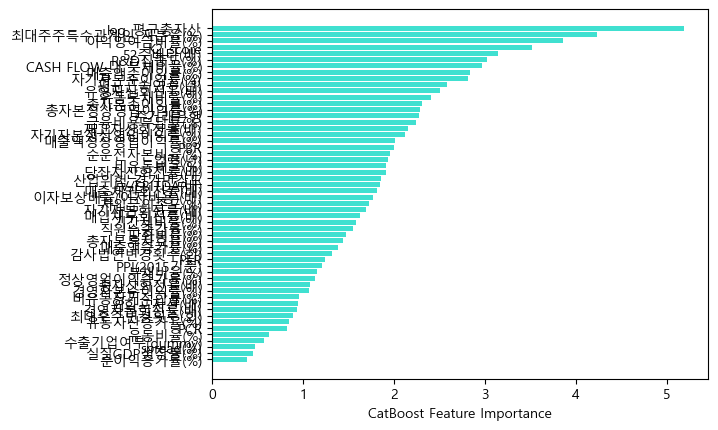

In [58]:
sorted_feature_importance = model.feature_importances_.argsort()
plt.barh(np.array(list(train_x))[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [59]:
Text(0.5, 0, 'CatBoost Feature Importance')

NameError: name 'Text' is not defined

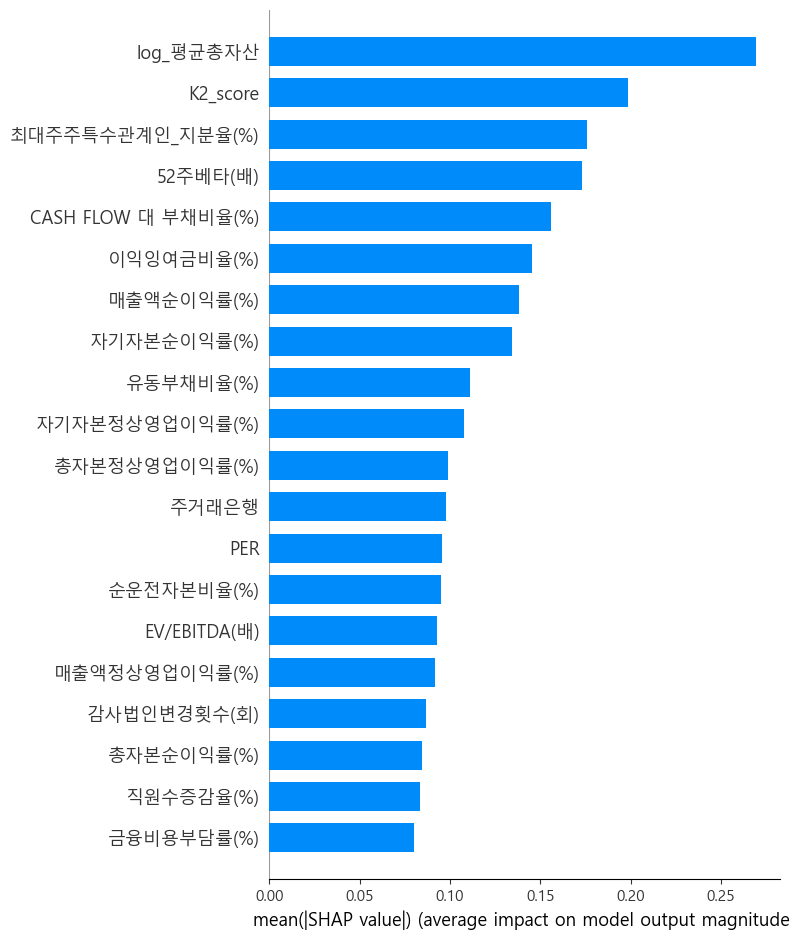

In [62]:
approximate = model.get_feature_importance(train_dataset, type="ShapValues", shap_calc_type="Approximate")[:, :-1]
shap.summary_plot(approximate, train_x,plot_type="bar")

Glyph 8722 (\N{MINUS SIGN}) missing from current font.


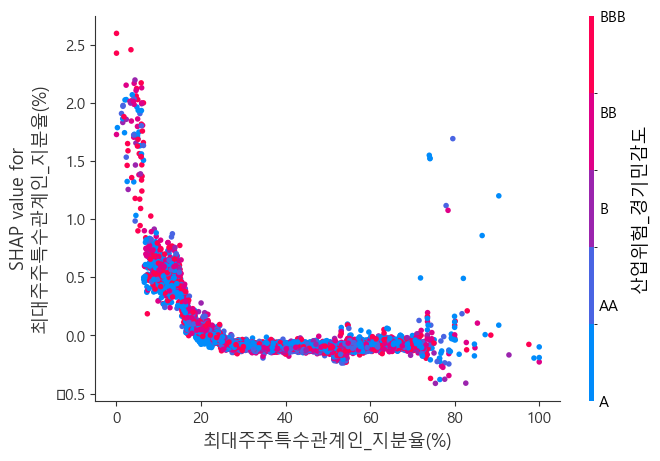

In [67]:
shap.dependence_plot("최대주주특수관계인_지분율(%)", approximate, train_x)

In [71]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(cb.Pool(train_x, train_y, cat_features=cat_features))

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Glyph 8722 (\N{MINUS SIGN}) missing from current font.
Glyph 8722 (\N{MINUS SIGN}) missing from current font.


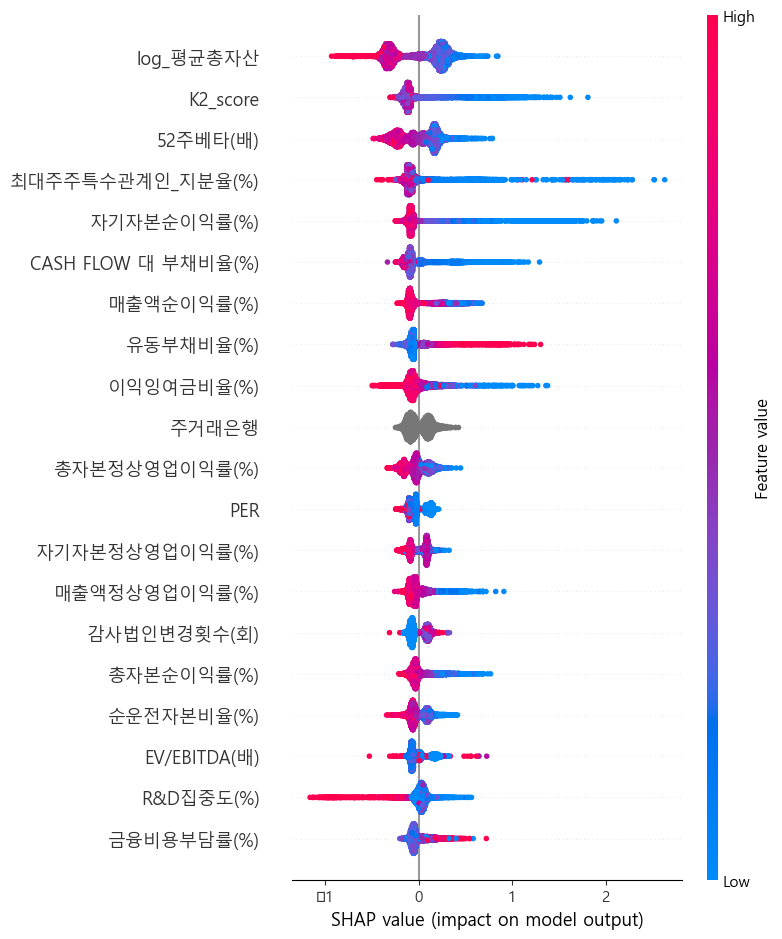

In [72]:
shap.summary_plot(shap_values, train_x)